## Capstone Project: Voice Cloning EDA & Model Comparison (Sample Data + Evaluation Placeholders)
This notebook generates sample voice data for 5 speakers, performs EDA, and provides placeholders for Your-tts, vts inference and evaluation.

In [ ]:
!pip install TTS
!pip install noisereduce
!pip install pandas
!pip install librosa
!pip install seaborn
!pip install speechbrain torchaudio # To analyse voice cloning quality


## Data preview (Audio files and speakers Preview)


In [1]:
import os
import pandas as pd
from pathlib import Path
import librosa

DATA_DIR = Path('data')
file_paths = []
speakers = []
durations = []

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            y, sr = librosa.load(path, sr=16000)
            file_paths.append(path)
            speakers.append(os.path.basename(root))
            durations.append(len(y)/sr)

df = pd.DataFrame({"path": file_paths, "speaker": speakers, "duration": durations})
print("Dataset preview:")
df.head()
print("\nTotal speakers:", df['speaker'].nunique())
print("Total audio files:", len(df))


Dataset preview:

Total speakers: 6
Total audio files: 68


## Exploratory Data Analysis

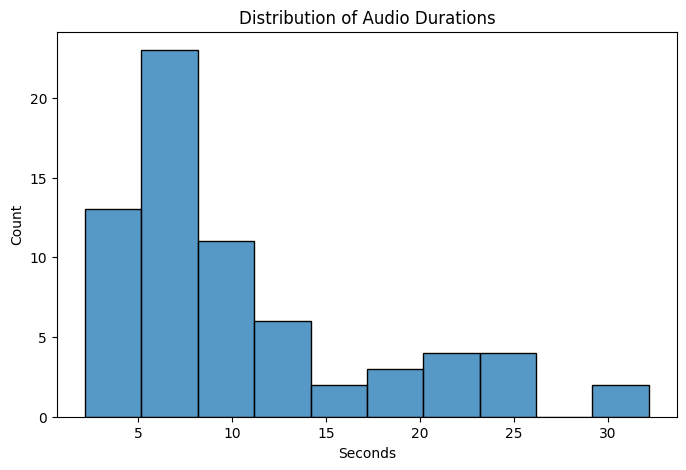

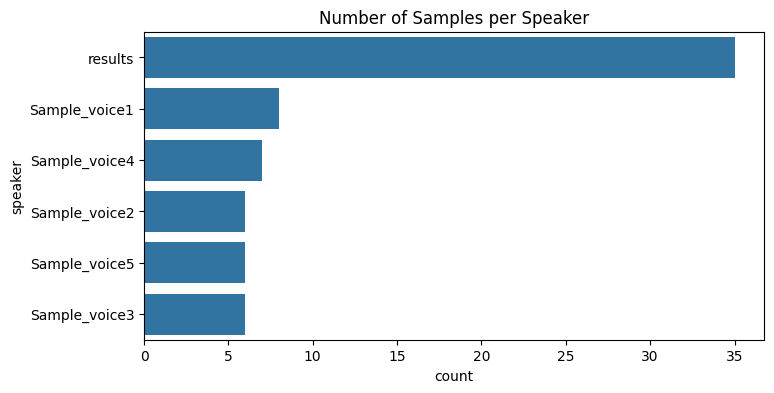

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Distribution of audio duration
plt.figure(figsize=(8,5))
sns.histplot(df['duration'], bins=10)
plt.title("Distribution of Audio Durations")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

# Speaker distribution
plt.figure(figsize=(8,4))
sns.countplot(y='speaker', data=df, order=df['speaker'].value_counts().index)
plt.title("Number of Samples per Speaker")
plt.show()


## Feature Extraction & Baseline Speaker Classification

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


def extract_mfcc(path, n_mfcc=13):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

X = np.array([extract_mfcc(p) for p in df['path']])
y = df['speaker']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Baseline classifier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline F1-score:", f1_score(y_test, y_pred, average='weighted'))


Baseline Accuracy: 0.9047619047619048
Baseline F1-score: 0.8928571428571429


## Model Inference Placeholders

In [4]:
#Testing TTS with simple model for voice cloning

from TTS.api import TTS

tts = TTS("tts_models/multilingual/multi-dataset/your_tts")
tts.tts_to_file(
    text="This Begins a New Practice This begins a series of weekly notes of Knowledge from Gurudev Sri Sri Ravi Shankar. Beyond an event is Knowledge. Beyond an object is Infinity. Beyond a person is Love. Knowledge is beyond events. Every event colours your awareness in some way. ",
    speaker_wav="data/Sample_voice5/p330_002.wav",
    file_path="data/Sample_voice5/results/your_tts_p330_002_out.wav",
    language="en")

 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

'data/Sample_voice5/results/your_tts_p330_002_out.wav'

In [41]:
## This code block execute only one model for voice cloning
from TTS.api import TTS
import os
import time
import glob

# Load the TTS model once
model_id = "tts_models/multilingual/multi-dataset/your_tts"
tts = TTS(model_id)

# Define texts (pages)
texts = {
    "Page1" : "This Begins a New Practice This begins a series of weekly notes of Knowledge from Gurudev Sri Sri Ravi Shankar. Beyond an event is Knowledge. Beyond an object is Infinity. Beyond a person is Love. Knowledge is beyond events. Every event colours your awareness in some way. ",
    "Page2" : "Close to the Master If you’re not feeling close to the Master, it’s because of you – because of your mind, your ego concepts. Just being on the levels of formal and informal communication cannot make you feel close. 'How are you?' 'Where are you going?' 'How have you been?'",
    "Page3" : "Prarabdha Karma and Sanchita Karma Some karma can be changed and some cannot. When you prepare a dessert, if sugar or ghee is too little, you can add more. If some other ingredient is too much, it can all be adjusted and repaired. But once it is cooked, it cannot be reversed. Milk can become sweet yoghurt or sour yoghurt, and sour yoghurt can be sweetened." 

}

# Number of sample voice folders
num_voices = 5

# Record overall start time
overall_start = time.time()

for v in range(1, num_voices + 1):
    voice_dir = f"data/Sample_voice{v}"
    results_dir = os.path.join(voice_dir, "results")
    os.makedirs(results_dir, exist_ok=True)

    # Find the first WAV file ending with _001.wav in the folder
    voice_files = glob.glob(os.path.join(voice_dir, "*_001.wav"))
    if not voice_files:
        print(f" No voice file ending with _001.wav found in {voice_dir}, skipping...")
        continue
    speaker_wav = voice_files[0]  # pick the first match
    file_name_prefix = os.path.splitext(os.path.basename(speaker_wav))[0]

    for page_name, text in texts.items():
        output_file = os.path.join(
            results_dir,
            f"{file_name_prefix}_{page_name}_{model_id.split('/')[-1]}.wav"
        )

        print(f"🔹 Generating | Voice {v} | {page_name} → {output_file}")
        start = time.time()
        tts.tts_to_file(
            text=text,
            speaker_wav=speaker_wav,
            file_path=output_file,
            language="en"
        )
        end = time.time()
        print(f"   ⏱️ Time taken: {round(end - start, 2)}s")

# Record overall end time
overall_end = time.time()
print(f"\n✅ Finished generating all outputs.")
print(f"⏱️ Total runtime: {round(overall_end - overall_start, 2)} seconds")


 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

## Analyzing voice cloning quality

In [5]:
#voice cloning for your_tts
import os
import glob
import torch
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from speechbrain.pretrained import EncoderClassifier
import logging
logging.getLogger("speechbrain.utils.parameter_transfer").setLevel(logging.WARNING)
logging.getLogger("speechbrain.dataio.encoder").setLevel(logging.WARNING)
logging.getLogger("speechbrain.utils.fetching").setLevel(logging.WARNING)
logging.getLogger("speechbrain.utils.checkpoints").setLevel(logging.WARNING)
logging.getLogger("speechbrain.utils.parameter_transfer").setLevel(logging.WARNING)
logging.getLogger("speechbrain.dataio.encoder").setLevel(logging.WARNING)


logging.basicConfig(level=logging.WARNING)

# --------------------------
# Load SpeechBrain ECAPA-TDNN
# --------------------------
spk_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa"
)

# --------------------------
# Settings
# --------------------------
num_voices = 5
pages = ["Page1", "Page2", "Page3"]
model_name = "your_tts"  # update if using multiple models
results_list = []

# --------------------------
# Loop through voices & pages
# --------------------------
for v in range(1, num_voices + 1):
    voice_dir = f"data/Sample_voice{v}"
    results_dir = os.path.join(voice_dir, "results")
    
    # Find original voice ending with _001.wav
    original_files = glob.glob(os.path.join(voice_dir, "*_001.wav"))
    if not original_files:
        print(f" No original voice found in {voice_dir}, skipping...")
        continue
    original_wav = original_files[0]
    
    # Load original audio
    signal, fs = torchaudio.load(original_wav)
    org_emb = spk_model.encode_batch(signal)
    org_emb_1d = org_emb.mean(dim=[0, 2])
    if org_emb.dim() > 1:
        org_emb = org_emb.mean(dim=0)  # reduce to 1D vector
    
    for page in pages:
        cloned_file = os.path.join(
            results_dir,
            f"{os.path.splitext(os.path.basename(original_wav))[0]}_{page}_{model_name}.wav"
        )
        if not os.path.exists(cloned_file):
            print(f" Cloned file not found: {cloned_file}, skipping...")
            continue
        
        # Load cloned audio
        cloned_signal, _ = torchaudio.load(cloned_file)
        cloned_emb = spk_model.encode_batch(cloned_signal)
        cloned_emb_1d = cloned_emb.mean(dim=[0, 2])
        if cloned_emb.dim() > 1:
            cloned_emb = cloned_emb.mean(dim=0)
        
        # Cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            org_emb_1d.unsqueeze(0),
            cloned_emb_1d.unsqueeze(0),
            dim=1).item()
        
        results_list.append({
            "Voice": f"Sample_voice{v}",
            "Page": page,
            "Original File": original_wav,
            "Cloned File": cloned_file,
            "Cosine Similarity": round(similarity, 4)
        })

your_tts_df = pd.DataFrame(results_list)

/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _sp

## Analytics and comparison between on Voice cloning quality for each voice samples

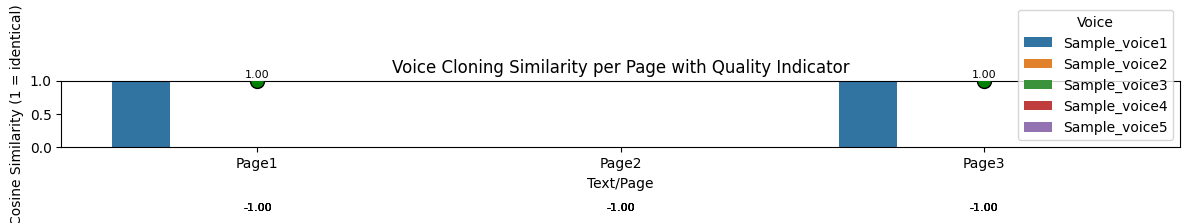

In [13]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Quality categorization
# --------------------------
def cloning_quality(sim):
    if sim >= 0.85:
        return "Excellent"
    elif sim >= 0.7:
        return "Moderate"
    else:
        return "Poor"

your_tts_df["Quality"] = your_tts_df["Cosine Similarity"].apply(cloning_quality)
quality_colors = {"Excellent": "green", "Moderate": "orange", "Poor": "red"}

# --------------------------
# Chart 1: Per Page with Quality Dots
# --------------------------
plt.figure(figsize=(12, 5))
sns.barplot(
    data=your_tts_df,
    x="Page",
    y="Cosine Similarity",
    hue="Voice",
    palette="tab10"
)

for i, row in your_tts_df.iterrows():
    plt.scatter(
        row["Page"],
        row["Cosine Similarity"],
        color=quality_colors[row["Quality"]],
        s=100,
        edgecolor="black",
        zorder=5
    )
    plt.text(
        row["Page"],
        row["Cosine Similarity"] + 0.01,
        f"{row['Cosine Similarity']:.2f}",
        ha="center", va="bottom", fontsize=8
    )

plt.title("Voice Cloning Similarity per Page with Quality Indicator")
plt.ylim(0, 1)
plt.ylabel("Cosine Similarity (1 = identical)")
plt.xlabel("Text/Page")
plt.legend(title="Voice")
plt.tight_layout()
plt.savefig("voice_similarity_per_page.png", dpi=300, bbox_inches="tight")
plt.show(block=True)

## Multimodel comparisons with given sample voices

In [9]:
# Cloned voice wav files are generated under data/sample_voice<number>/results/<file_name>_<model_name>_<page_name>.wav
%matplotlib inline
import os
import glob
import torch
import torchaudio
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from TTS.api import TTS
from speechbrain.pretrained import EncoderClassifier
import logging
logging.getLogger("speechbrain.utils.parameter_transfer").setLevel(logging.WARNING)
logging.getLogger("speechbrain.dataio.encoder").setLevel(logging.WARNING)
logging.getLogger("speechbrain.utils.fetching").setLevel(logging.WARNING)

logging.basicConfig(level=logging.WARNING)

# --------------------------
# Settings
# --------------------------
num_voices = 5
pages = ["Page1", "Page2", "Page3"]
texts = {
    "Page1" : "This Begins a New Practice This begins a series of weekly notes of Knowledge from Gurudev Sri Sri Ravi Shankar. Beyond an event is Knowledge. Beyond an object is Infinity. Beyond a person is Love. Knowledge is beyond events. Every event colours your awareness in some way. ",
    "Page2" : "Close to the Master If you’re not feeling close to the Master, it’s because of you – because of your mind, your ego concepts. Just being on the levels of formal and informal communication cannot make you feel close. 'How are you?' 'Where are you going?' 'How have you been?'",
    "Page3" : "Prarabdha Karma and Sanchita Karma Some karma can be changed and some cannot. When you prepare a dessert, if sugar or ghee is too little, you can add more. If some other ingredient is too much, it can all be adjusted and repaired. But once it is cooked, it cannot be reversed. Milk can become sweet yoghurt or sour yoghurt, and sour yoghurt can be sweetened." 

}

# Define TTS models
tts_models = [
    "tts_models/multilingual/multi-dataset/your_tts",
    #"tts_models/multilingual/multi-dataset/xtts_v2"
    "tts_models/en/ljspeech/vits"
]

# --------------------------
# Load Speaker Embedding Model
# --------------------------
spk_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa"
)

# --------------------------
# Run TTS and Compute Similarity
# --------------------------
results_list = []

for v in range(1, num_voices + 1):
    voice_dir = f"data/Sample_voice{v}"
    results_dir = os.path.join(voice_dir, "results")
    os.makedirs(results_dir, exist_ok=True)

    # Find original voice file ending with _001.wav
    original_files = glob.glob(os.path.join(voice_dir, "*_001.wav"))
    if not original_files:
        print(f"No original voice found in {voice_dir}, skipping...")
        continue
    original_wav = original_files[0]

    # Load original audio
    signal, fs = torchaudio.load(original_wav)
    org_emb = spk_model.encode_batch(signal)
    if org_emb.dim() > 1:
        org_emb = org_emb.mean(dim=[0, 2])  # 1D vector

    for model_id in tts_models:
        tts_model_name = model_id.split("/")[-1]
        tts = TTS(model_id)

        for page_name in pages:
            # Output file
            output_file = os.path.join(
                results_dir,
                f"{os.path.splitext(os.path.basename(original_wav))[0]}_{page_name}_{tts_model_name}.wav"
            )

            # Generate TTS if file does not exist
            if not os.path.exists(output_file):
                if "multilingual" in model_id:
                    tts.tts_to_file(
                        text=texts[page_name],
                        speaker_wav=original_wav,
                        file_path=output_file,
                        language="en")
                elif "xtts_v2" in model_id:
                    import TTS.tts.configs.xtts_config
                    torch.serialization.safe_globals([TTS.tts.configs.xtts_config.XttsConfig])
                    tts.tts_to_file(
                        text=texts[page_name],
                        speaker_wav=original_wav,
                        file_path=output_file,
                        weights_only=True,
                        language="en")

                else:
                    tts.tts_to_file(
                        text=texts[page_name],
                        speaker_wav=original_wav,
                        file_path=output_file)

            # Load cloned audio
            cloned_signal, _ = torchaudio.load(output_file)
            cloned_emb = spk_model.encode_batch(cloned_signal)
            if cloned_emb.dim() > 1:
                cloned_emb = cloned_emb.mean(dim=[0, 2])

            # Cosine similarity
            similarity = torch.nn.functional.cosine_similarity(
                org_emb.unsqueeze(0),
                cloned_emb.unsqueeze(0),
                dim=1).item()

            results_list.append({
                "Voice": f"Sample_voice{v}",
                "Page": page_name,
                "Model": tts_model_name,
                "Original File": original_wav,
                "Cloned File": output_file,
                "Cosine Similarity": round(similarity, 4)
            })

# --------------------------
# Save results to CSV
# --------------------------
df = pd.DataFrame(results_list)
df.to_csv("multi_model_voice_similarity.csv", index=False)
print(" Multi-model similarity results saved to CSV")
print(df.head())


/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

/opt/anaconda3/envs/tts_env/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


 Multi-model similarity results saved to CSV
           Voice   Page     Model                    Original File  \
0  Sample_voice1  Page1  your_tts  data/Sample_voice1/p340_001.wav   
1  Sample_voice1  Page2  your_tts  data/Sample_voice1/p340_001.wav   
2  Sample_voice1  Page3  your_tts  data/Sample_voice1/p340_001.wav   
3  Sample_voice1  Page1      vits  data/Sample_voice1/p340_001.wav   
4  Sample_voice1  Page2      vits  data/Sample_voice1/p340_001.wav   

                                         Cloned File  Cosine Similarity  
0  data/Sample_voice1/results/p340_001_Page1_your...                1.0  
1  data/Sample_voice1/results/p340_001_Page2_your...               -1.0  
2  data/Sample_voice1/results/p340_001_Page3_your...                1.0  
3  data/Sample_voice1/results/p340_001_Page1_vits...               -1.0  
4  data/Sample_voice1/results/p340_001_Page2_vits...               -1.0  


## Voice Cloning Quality analysis and comparisons - Multimodel

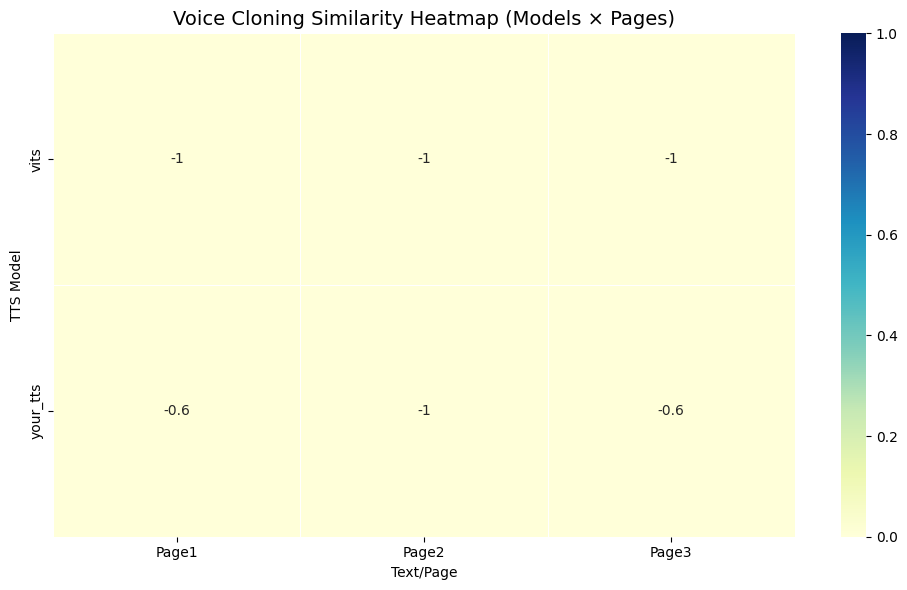

In [10]:
#Voice Cloning Similarity Heatmap (Models × Pages)
plt.figure(figsize=(10, 6))
pivot_df = df.pivot_table(
    index="Model", columns="Page", values="Cosine Similarity", aggfunc="mean"
)
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", vmin=0, vmax=1, cbar=True, linewidths=0.5)
plt.title("Voice Cloning Similarity Heatmap (Models × Pages)", fontsize=14)
plt.ylabel("TTS Model")
plt.xlabel("Text/Page")
plt.tight_layout()
plt.show()

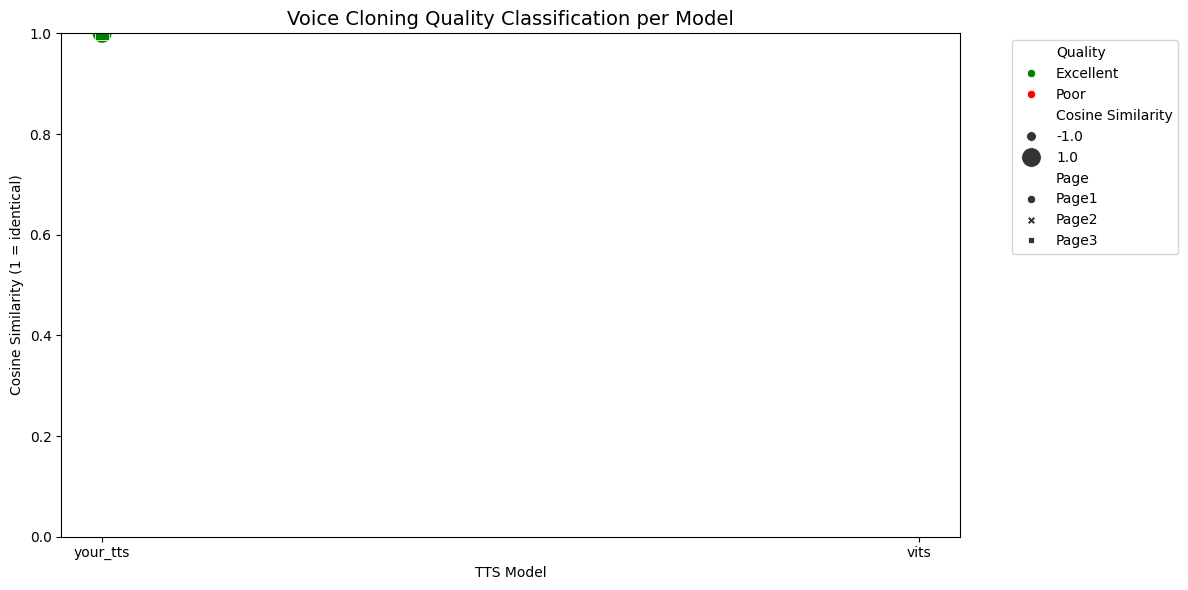

In [11]:
#Voice Cloning Quality Classification per Model
def cloning_quality(sim):
    if sim >= 0.85:
        return "Excellent"
    elif sim >= 0.7:
        return "Moderate"
    else:
        return "Poor"

df["Quality"] = df["Cosine Similarity"].apply(cloning_quality)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="Model",
    y="Cosine Similarity",
    hue="Quality",
    style="Page",
    size="Cosine Similarity",
    sizes=(50, 200),
    palette={"Excellent": "green", "Moderate": "orange", "Poor": "red"}
)
plt.title("Voice Cloning Quality Classification per Model", fontsize=14)
plt.ylim(0, 1)
plt.ylabel("Cosine Similarity (1 = identical)")
plt.xlabel("TTS Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


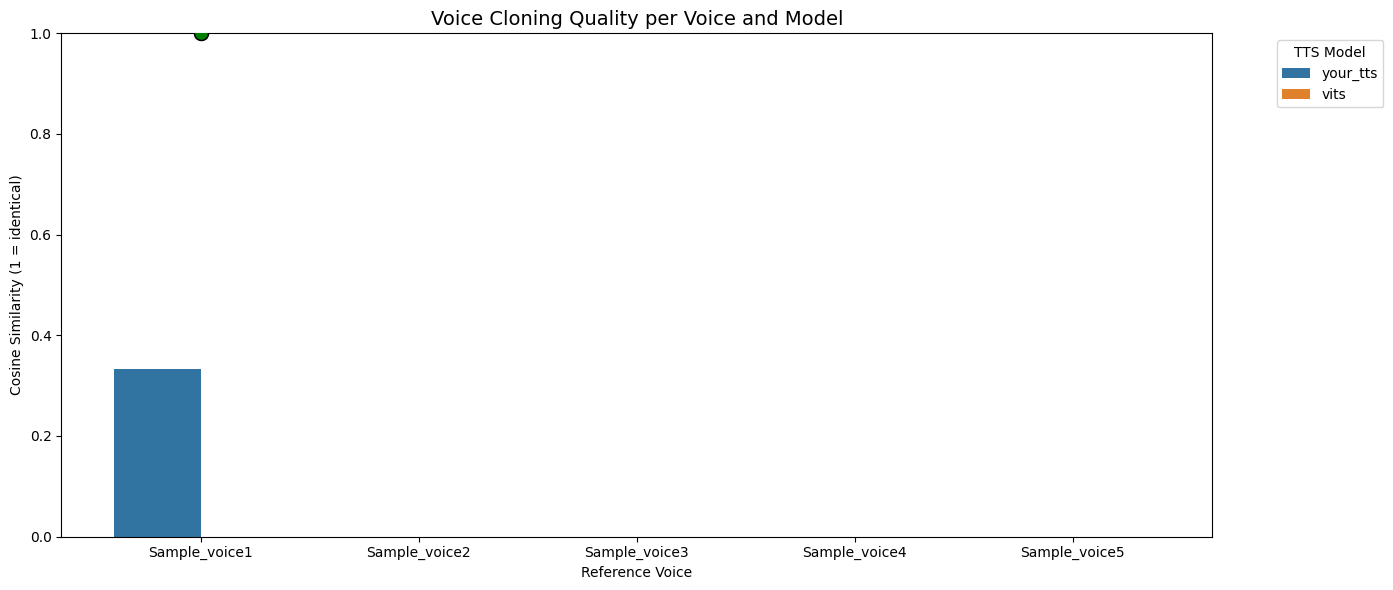

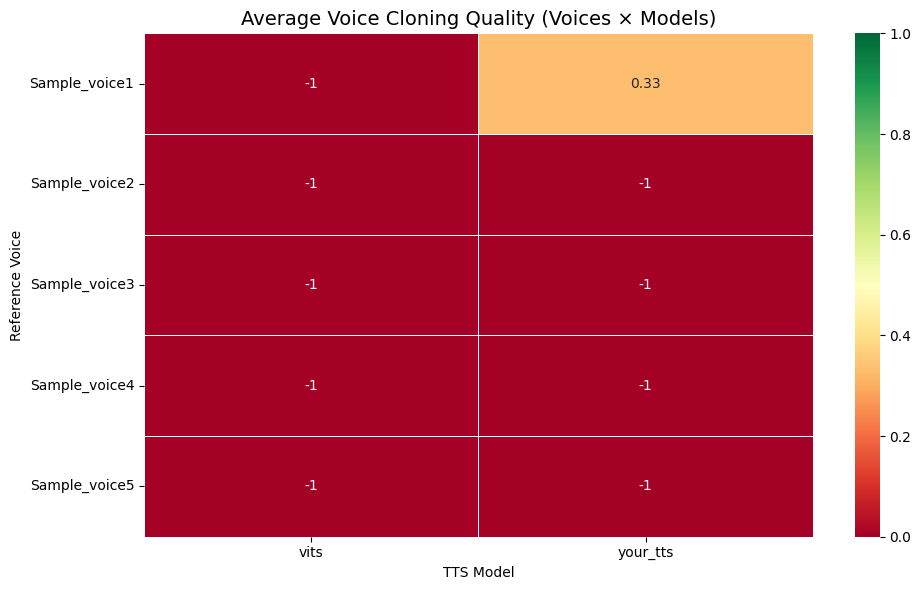

In [12]:
#Voice Cloning Quality per Voice and Model
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume df is already created
# Columns: ["Voice", "Page", "Model", "Cosine Similarity"]

# --------------------------
# Add Quality Labels
# --------------------------
def cloning_quality(sim):
    if sim >= 0.85:
        return "Excellent"
    elif sim >= 0.7:
        return "Moderate"
    else:
        return "Poor"

df["Quality"] = df["Cosine Similarity"].apply(cloning_quality)

# --------------------------
# 1. Grouped Bar Plot per Voice × Model
# --------------------------
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df,
    x="Voice",
    y="Cosine Similarity",
    hue="Model",
    errorbar=None,
    palette="tab10"
)

# Overlay quality dots
quality_colors = {"Excellent": "green", "Moderate": "orange", "Poor": "red"}
for i, row in df.iterrows():
    plt.scatter(
        x=row["Voice"],
        y=row["Cosine Similarity"],
        color=quality_colors[row["Quality"]],
        s=100,
        edgecolor="black",
        zorder=5
    )

plt.title("Voice Cloning Quality per Voice and Model", fontsize=14)
plt.ylim(0, 1)
plt.ylabel("Cosine Similarity (1 = identical)")
plt.xlabel("Reference Voice")
plt.legend(title="TTS Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("voice_quality_barplot.png", dpi=300)
plt.show()

# --------------------------
# 2. Heatmap: Voices × Models
# --------------------------
plt.figure(figsize=(10, 6))
pivot_df = df.pivot_table(
    index="Voice", columns="Model", values="Cosine Similarity", aggfunc="mean"
)
sns.heatmap(
    pivot_df, annot=True, cmap="RdYlGn", vmin=0, vmax=1, linewidths=0.5
)

plt.title("Average Voice Cloning Quality (Voices × Models)", fontsize=14)
plt.ylabel("Reference Voice")
plt.xlabel("TTS Model")
plt.tight_layout()
plt.savefig("voice_quality_heatmap.png", dpi=300)
plt.show()
